Importing the libaries

In [ ]:
# Sklearn
from sklearn.model_selection import train_test_split, KFold

# Tensorflow
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model

# Plotting tools
import matplotlib.pyplot as plt

# Other modules
import pandas as pd
import numpy as np

Load the data and check for Not a Number (Nan)

In [ ]:
# Load training and testing data
train_data = pd.read_csv('train-1.csv')
test_data = pd.read_csv('test.csv')

# Check for nan and dupes data
print(train_data.isna().sum())
print("-"*30)
print(f"Number of NaN values: {train_data.isna().sum().sum()}")

print(test_data.isna().sum())
print("-"*30)
print(f"Number of NaN values: {test_data.isna().sum().sum()}")

arousal                   0
dynamics_rms_mean         0
dynamics_rms_std          0
pitch_pitch_mean          0
rhythm_attacktime_mean    0
                         ..
tonal_hcdf_std            0
tonal_keyclarity_mean     0
tonal_keyclarity_std      0
tonal_mode_mean           0
tonal_mode_std            0
Length: 69, dtype: int64
------------------------------
Number of NaN values: 0
arousal                   0
dynamics_rms_mean         0
dynamics_rms_std          0
pitch_pitch_mean          0
rhythm_attacktime_mean    0
                         ..
tonal_hcdf_std            0
tonal_keyclarity_mean     0
tonal_keyclarity_std      0
tonal_mode_mean           0
tonal_mode_std            0
Length: 69, dtype: int64
------------------------------
Number of NaN values: 0


Assigning the X with everything except the "arousal" column, and Y with just the "arousal" column

In [ ]:
X = train_data.drop(labels="arousal", axis=1).values
y = train_data["arousal"].values

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (500, 68)
Shape of y: (500,)


Defining the MLP Model with the learning rate (0.0001)

In [ ]:
 # For storing evaluation outputs
 results = []

 # Define the Hyperparameters
 widths = [32, 1024]
 depths = [2, 4]

 # For storing the best parameters
 best_width = None
 best_depth = None
 best_loss = float('inf')
 best_model = None

 # Going through the all possible combinations of the hyperparameters
 for width in widths:
   for depth in depths:
      print(f"Width: {width}, Depth: {depth}")

      # For storing the train and val loss for one hyperparameter combination
      train_losses = []
      val_losses = []

      # N fold cross validation starts
      for train_index, val_index in KFold(n_splits=5, shuffle=True, random_state=777).split(X):
            # Splitting data train and data validation
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Define the model
            model = tf.keras.models.Sequential()
              # Input layer
            model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))   # or tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train1.shape[1],))

              # Hidden layers
            for _ in range(depth):
              model.add(tf.keras.layers.Dense(width, activation='relu'))
              # Output layer
            model.add(tf.keras.layers.Dense(1, activation='linear'))

            # Compile the model, mse = Mean Square Error, mae = Mean Absolute Error
            model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

            model.summary()
            # Train the model
            history = model.fit(
                x=X_train,
                y=y_train,
                epochs=60,
                batch_size=8,
                validation_data=(X_val, y_val),
                verbose=2,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
              )
            # Evaluate the model on the training and validation set
            train_loss = model.evaluate(X_train, y_train, verbose = 0)
            val_loss = model.evaluate(X_val, y_val, verbose = 0)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

      avg_train_loss = np.mean(train_losses)
      avg_val_loss = np.mean(val_losses)
      print(f"Mean training loss: {avg_train_loss :.4f} -- Mean validation loss: {avg_val_loss:.4f} -- Hyperparameters: (Width: {width}, Depth: {depth})")

      results.append((width, depth, avg_train_loss, avg_val_loss))
      # Determining the hyperparameters with the best loss
      if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_width = width
        best_depth = depth
        best_model = model
 print(f"\n--------------------- Best Random Audio Classifier with Hyperparameters = (Best Width: {best_width}, Best Depth: {best_depth}) ---------------------")
 print(f"\nTraining Loss: {best_loss : .4f}")

 # Test data
 X_test1 = test_data.drop(["arousal"], axis=1).values
 y_test1 = test_data["arousal"].values

 loss = best_model.evaluate(X_test1, y_test1, verbose=0)
 print(f"Test Loss: {loss}")

 predictions = best_model.predict(X_test1)
 predictions
 for i in range(len(y_test1)):
  print(f"Target: {y_test1[i]} -- Prediction: {predictions[i][0]}")

Width: 32, Depth: 2


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,297 (12.88 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 2s - 39ms/step - loss: 731233.3750 - mae: 548.0731 - val_loss: 48330.4414 - val_mae: 174.9479
Epoch 2/60
50/50 - 1s - 16ms/step - loss: 15248.2617 - mae: 87.1657 - val_loss: 4994.0264 - val_mae: 56.1384
Epoch 3/60
50/50 - 0s - 6ms/step - loss: 5197.6948 - mae: 52.7256 - val_loss: 2859.7476 - val_mae: 40.7148
Epoch 4/60
50/50 - 0s - 6ms/step - loss: 3784.9277 - mae: 44.4622 - val_loss: 2903.0227 - val_mae: 41.4704
Epoch 5/60
50/50 - 0s - 4ms/step - loss: 3016.3843 - mae: 40.0489 - val_loss: 1985.6925 - val_mae: 33.8975
Epoch 6/60
50/50 - 0s - 4ms/step - loss: 2891.9099 - mae: 37.9361 - val_loss: 2221.2468 - val_mae: 35.2741
Epoch 7/60
50/50 - 0s - 7ms/step - loss: 2121.8994 - mae: 32.5211 - val_loss: 1592.4519 - val_mae: 29.8288
Epoch 8/60
50/50 - 0s - 5ms/step - loss: 1719.7091 - mae: 30.0327 - val_loss: 1443.9716 - val_mae: 28.8028
Epoch 9/60
50/50 - 0s - 6ms/step - loss: 1808.5465 - mae: 28.6098 - val_loss: 1272.1708 - val_mae: 26.5573
Epoch 10/60
50/50 - 0s - 6ms/

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,297 (12.88 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 1s - 29ms/step - loss: 112524.1797 - mae: 191.8297 - val_loss: 16954.7520 - val_mae: 115.5653
Epoch 2/60
50/50 - 0s - 9ms/step - loss: 10127.8711 - mae: 75.7304 - val_loss: 5529.0977 - val_mae: 61.9033
Epoch 3/60
50/50 - 0s - 6ms/step - loss: 3696.4780 - mae: 49.5203 - val_loss: 2510.5415 - val_mae: 38.4700
Epoch 4/60
50/50 - 0s - 6ms/step - loss: 2383.5527 - mae: 38.4851 - val_loss: 1883.1570 - val_mae: 32.5075
Epoch 5/60
50/50 - 0s - 6ms/step - loss: 1741.3778 - mae: 32.9050 - val_loss: 1671.1439 - val_mae: 31.7862
Epoch 6/60
50/50 - 0s - 6ms/step - loss: 1607.2410 - mae: 31.7781 - val_loss: 1570.8744 - val_mae: 31.2488
Epoch 7/60
50/50 - 0s - 6ms/step - loss: 1364.9777 - mae: 28.8097 - val_loss: 1249.4088 - val_mae: 26.7442
Epoch 8/60
50/50 - 0s - 6ms/step - loss: 1418.0881 - mae: 28.9149 - val_loss: 1238.7147 - val_mae: 24.8476
Epoch 9/60
50/50 - 0s - 4ms/step - loss: 1317.8417 - mae: 29.3717 - val_loss: 954.7576 - val_mae: 23.3292
Epoch 10/60
50/50 - 0s - 4ms/st

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,297 (12.88 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 1s - 29ms/step - loss: 53725.7305 - mae: 150.4638 - val_loss: 10610.4287 - val_mae: 69.0282
Epoch 2/60
50/50 - 0s - 8ms/step - loss: 6985.0942 - mae: 61.3341 - val_loss: 4705.5273 - val_mae: 48.4146
Epoch 3/60
50/50 - 0s - 6ms/step - loss: 4211.7983 - mae: 48.6805 - val_loss: 4241.2017 - val_mae: 46.0229
Epoch 4/60
50/50 - 0s - 6ms/step - loss: 3122.6951 - mae: 41.6281 - val_loss: 3591.5349 - val_mae: 42.9790
Epoch 5/60
50/50 - 0s - 6ms/step - loss: 2333.9712 - mae: 36.5221 - val_loss: 3271.3018 - val_mae: 41.9112
Epoch 6/60
50/50 - 0s - 6ms/step - loss: 1890.9385 - mae: 32.6475 - val_loss: 2603.5818 - val_mae: 36.1567
Epoch 7/60
50/50 - 0s - 6ms/step - loss: 1619.2651 - mae: 31.0021 - val_loss: 2365.9915 - val_mae: 33.2693
Epoch 8/60
50/50 - 0s - 6ms/step - loss: 1414.8414 - mae: 28.7855 - val_loss: 2152.7930 - val_mae: 32.3088
Epoch 9/60
50/50 - 0s - 3ms/step - loss: 1307.4711 - mae: 27.7051 - val_loss: 1753.5613 - val_mae: 29.1303
Epoch 10/60
50/50 - 0s - 6ms/step

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,297 (12.88 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 1s - 28ms/step - loss: 34313.6836 - mae: 122.2684 - val_loss: 14059.9072 - val_mae: 72.2184
Epoch 2/60
50/50 - 0s - 10ms/step - loss: 3813.4697 - mae: 46.8051 - val_loss: 2811.5212 - val_mae: 41.3353
Epoch 3/60
50/50 - 0s - 4ms/step - loss: 5467.1860 - mae: 41.5131 - val_loss: 3422.6013 - val_mae: 40.3953
Epoch 4/60
50/50 - 0s - 7ms/step - loss: 3137.3057 - mae: 37.4865 - val_loss: 31084.3750 - val_mae: 58.5949
Epoch 5/60
50/50 - 0s - 6ms/step - loss: 2261.1538 - mae: 29.1342 - val_loss: 1093.0253 - val_mae: 26.1220
Epoch 6/60
50/50 - 0s - 6ms/step - loss: 1466.4253 - mae: 24.9243 - val_loss: 25051.6309 - val_mae: 52.5462
Epoch 7/60
50/50 - 0s - 6ms/step - loss: 1768.2887 - mae: 24.0383 - val_loss: 4012.7927 - val_mae: 31.0998
Epoch 8/60
50/50 - 0s - 4ms/step - loss: 734.7431 - mae: 18.4031 - val_loss: 3105.5444 - val_mae: 27.2706
Epoch 9/60
50/50 - 0s - 6ms/step - loss: 660.4003 - mae: 17.4364 - val_loss: 3024.6165 - val_mae: 25.0987
Epoch 10/60
50/50 - 0s - 4ms/ste

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,297 (12.88 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 2s - 39ms/step - loss: 12264.2236 - mae: 71.4800 - val_loss: 4539.9502 - val_mae: 49.9340
Epoch 2/60
50/50 - 0s - 8ms/step - loss: 2930.4880 - mae: 40.7046 - val_loss: 1977.3080 - val_mae: 32.9496
Epoch 3/60
50/50 - 0s - 4ms/step - loss: 1864.5422 - mae: 31.6941 - val_loss: 1934.0802 - val_mae: 32.3565
Epoch 4/60
50/50 - 0s - 6ms/step - loss: 1483.3533 - mae: 28.2294 - val_loss: 2571.1702 - val_mae: 37.6059
Epoch 5/60
50/50 - 0s - 6ms/step - loss: 1596.4048 - mae: 25.0164 - val_loss: 2161.4365 - val_mae: 33.4639
Epoch 6/60
50/50 - 0s - 4ms/step - loss: 1023.8363 - mae: 23.6092 - val_loss: 674.6297 - val_mae: 18.6742
Epoch 7/60
50/50 - 0s - 6ms/step - loss: 1165.6370 - mae: 24.5895 - val_loss: 2341.6567 - val_mae: 24.5414
Epoch 8/60
50/50 - 0s - 6ms/step - loss: 1031.8616 - mae: 20.0104 - val_loss: 631.0916 - val_mae: 16.4925
Epoch 9/60
50/50 - 0s - 6ms/step - loss: 2479.4705 - mae: 27.3891 - val_loss: 4222.1958 - val_mae: 28.2931
Epoch 10/60
50/50 - 0s - 5ms/step - l

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 3s - 57ms/step - loss: 147468.0938 - mae: 199.3323 - val_loss: 3317.2051 - val_mae: 44.9707
Epoch 2/60
50/50 - 0s - 4ms/step - loss: 776.9791 - mae: 18.8826 - val_loss: 360.2523 - val_mae: 12.0546
Epoch 3/60
50/50 - 0s - 5ms/step - loss: 294.5284 - mae: 11.4855 - val_loss: 236.7703 - val_mae: 10.1618
Epoch 4/60
50/50 - 0s - 4ms/step - loss: 189.3546 - mae: 9.4679 - val_loss: 174.9333 - val_mae: 9.1064
Epoch 5/60
50/50 - 0s - 6ms/step - loss: 147.8809 - mae: 8.5903 - val_loss: 112.6205 - val_mae: 7.9424
Epoch 6/60
50/50 - 0s - 6ms/step - loss: 120.7113 - mae: 7.6788 - val_loss: 131.7968 - val_mae: 7.8090
Epoch 7/60
50/50 - 0s - 6ms/step - loss: 102.4330 - mae: 7.2917 - val_loss: 96.9601 - val_mae: 7.3245
Epoch 8/60
50/50 - 0s - 4ms/step - loss: 92.0750 - mae: 7.0516 - val_loss: 116.8312 - val_mae: 7.1614
Epoch 9/60
50/50 - 0s - 4ms/step - loss: 81.5836 - mae: 6.4694 - val_loss: 85.8653 - val_mae: 6.6770
Epoch 10/60
50/50 - 0s - 6ms/step - loss: 69.2722 - mae: 6.0338 -

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 2s - 48ms/step - loss: 3246.0657 - mae: 37.6726 - val_loss: 285.5803 - val_mae: 10.4583
Epoch 2/60
50/50 - 0s - 7ms/step - loss: 218.9195 - mae: 10.0276 - val_loss: 136.2257 - val_mae: 6.8691
Epoch 3/60
50/50 - 1s - 13ms/step - loss: 114.1446 - mae: 7.6686 - val_loss: 209.1408 - val_mae: 11.3629
Epoch 4/60
50/50 - 0s - 10ms/step - loss: 215.9396 - mae: 9.0041 - val_loss: 100.7002 - val_mae: 5.8393
Epoch 5/60
50/50 - 0s - 6ms/step - loss: 759.2198 - mae: 12.4557 - val_loss: 84.1242 - val_mae: 6.2473
Epoch 6/60
50/50 - 0s - 4ms/step - loss: 348.0616 - mae: 10.2678 - val_loss: 80.4119 - val_mae: 5.6824
Epoch 7/60
50/50 - 0s - 7ms/step - loss: 103.0837 - mae: 5.6328 - val_loss: 45.8881 - val_mae: 4.6647
Epoch 8/60
50/50 - 0s - 5ms/step - loss: 86.1013 - mae: 4.8489 - val_loss: 48.7775 - val_mae: 4.3275
Epoch 9/60
50/50 - 0s - 7ms/step - loss: 30.4847 - mae: 3.8956 - val_loss: 45.2269 - val_mae: 4.4274
Epoch 10/60
50/50 - 0s - 4ms/step - loss: 34.8442 - mae: 3.9384 - val_

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                     │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 3s - 55ms/step - loss: 22886.3301 - mae: 90.3486 - val_loss: 3090.9495 - val_mae: 26.2421
Epoch 2/60
50/50 - 0s - 4ms/step - loss: 1146.8931 - mae: 19.8922 - val_loss: 428.9862 - val_mae: 14.3455
Epoch 3/60
50/50 - 0s - 6ms/step - loss: 325.2034 - mae: 12.9761 - val_loss: 344.9646 - val_mae: 12.2478
Epoch 4/60
50/50 - 0s - 4ms/step - loss: 224.7838 - mae: 10.8456 - val_loss: 288.4273 - val_mae: 10.9248
Epoch 5/60
50/50 - 0s - 4ms/step - loss: 170.4971 - mae: 9.5447 - val_loss: 240.6356 - val_mae: 9.9224
Epoch 6/60
50/50 - 0s - 6ms/step - loss: 159.1366 - mae: 9.1920 - val_loss: 236.8651 - val_mae: 9.4356
Epoch 7/60
50/50 - 0s - 6ms/step - loss: 126.2380 - mae: 8.1422 - val_loss: 219.7973 - val_mae: 8.8475
Epoch 8/60
50/50 - 0s - 6ms/step - loss: 102.5228 - mae: 7.3387 - val_loss: 188.5726 - val_mae: 8.3734
Epoch 9/60
50/50 - 0s - 6ms/step - loss: 103.1338 - mae: 7.2051 - val_loss: 302.0670 - val_mae: 8.3561
Epoch 10/60
50/50 - 0s - 4ms/step - loss: 110.0296 - mae: 7.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 2s - 49ms/step - loss: 113625.2969 - mae: 175.5437 - val_loss: 3846.5750 - val_mae: 41.7611
Epoch 2/60
50/50 - 0s - 7ms/step - loss: 1195.3901 - mae: 22.5935 - val_loss: 1759.4474 - val_mae: 24.1148
Epoch 3/60
50/50 - 0s - 6ms/step - loss: 544.5279 - mae: 16.0297 - val_loss: 1196.9348 - val_mae: 19.3899
Epoch 4/60
50/50 - 0s - 6ms/step - loss: 383.4962 - mae: 13.0027 - val_loss: 962.1512 - val_mae: 17.4792
Epoch 5/60
50/50 - 0s - 6ms/step - loss: 327.7379 - mae: 11.9104 - val_loss: 835.4905 - val_mae: 16.1779
Epoch 6/60
50/50 - 0s - 6ms/step - loss: 243.9866 - mae: 10.3653 - val_loss: 873.7844 - val_mae: 15.0631
Epoch 7/60
50/50 - 0s - 7ms/step - loss: 207.6891 - mae: 9.5011 - val_loss: 778.9603 - val_mae: 15.6717
Epoch 8/60
50/50 - 0s - 8ms/step - loss: 185.8055 - mae: 9.6034 - val_loss: 902.7988 - val_mae: 14.0663
Epoch 9/60
50/50 - 0s - 5ms/step - loss: 147.7795 - mae: 8.2727 - val_loss: 963.8865 - val_mae: 14.4057
Epoch 10/60
50/50 - 0s - 4ms/step - loss: 130.341

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                     │ (None, 32)                  │           2,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 2s - 42ms/step - loss: 17840.4551 - mae: 94.8474 - val_loss: 5113.4980 - val_mae: 53.5176
Epoch 2/60
50/50 - 0s - 5ms/step - loss: 2541.4221 - mae: 37.8213 - val_loss: 1677.8269 - val_mae: 33.0949
Epoch 3/60
50/50 - 0s - 4ms/step - loss: 1400.3225 - mae: 28.2321 - val_loss: 3084.3674 - val_mae: 47.4726
Epoch 4/60
50/50 - 0s - 6ms/step - loss: 822.2369 - mae: 22.3063 - val_loss: 787.5126 - val_mae: 21.5756
Epoch 5/60
50/50 - 0s - 6ms/step - loss: 452.1548 - mae: 15.8413 - val_loss: 558.7303 - val_mae: 18.8969
Epoch 6/60
50/50 - 0s - 6ms/step - loss: 368.2422 - mae: 14.5662 - val_loss: 298.8300 - val_mae: 12.7610
Epoch 7/60
50/50 - 0s - 6ms/step - loss: 339.3935 - mae: 13.7815 - val_loss: 591.5637 - val_mae: 19.7117
Epoch 8/60
50/50 - 0s - 5ms/step - loss: 331.7756 - mae: 14.1332 - val_loss: 992.6956 - val_mae: 26.8410
Epoch 9/60
50/50 - 0s - 6ms/step - loss: 477.9412 - mae: 16.9866 - val_loss: 636.9948 - val_mae: 20.7930
Epoch 10/60
50/50 - 0s - 6ms/step - loss: 377.8

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 1024)                │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121,281 (4.28 MB)

 Trainable params: 1,121,281 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 2s - 44ms/step - loss: 1101184.1250 - mae: 584.8013 - val_loss: 35430.6641 - val_mae: 162.8602
Epoch 2/60
50/50 - 1s - 26ms/step - loss: 26255.9727 - mae: 84.8647 - val_loss: 5682.6123 - val_mae: 65.7365
Epoch 3/60
50/50 - 1s - 23ms/step - loss: 3459.8054 - mae: 33.7059 - val_loss: 695.1755 - val_mae: 13.9364
Epoch 4/60
50/50 - 1s - 17ms/step - loss: 1124.3951 - mae: 20.8262 - val_loss: 363.7111 - val_mae: 9.4558
Epoch 5/60
50/50 - 1s - 15ms/step - loss: 211.8514 - mae: 8.6853 - val_loss: 824.8529 - val_mae: 10.8949
Epoch 6/60
50/50 - 1s - 26ms/step - loss: 565.0959 - mae: 12.1290 - val_loss: 691.9684 - val_mae: 15.8819
Epoch 7/60
50/50 - 1s - 25ms/step - loss: 1105.9287 - mae: 16.1619 - val_loss: 385.2007 - val_mae: 11.3462
Epoch 8/60
50/50 - 1s - 25ms/step - loss: 715.3639 - mae: 16.6785 - val_loss: 74.2741 - val_mae: 6.6211
Epoch 9/60
50/50 - 1s - 15ms/step - loss: 225.3391 - mae: 9.7252 - val_loss: 285.0567 - val_mae: 13.1297
Epoch 10/60
50/50 - 1s - 15ms/step - 

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                     │ (None, 1024)                │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121,281 (4.28 MB)

 Trainable params: 1,121,281 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 2s - 41ms/step - loss: 2458209.2500 - mae: 926.4310 - val_loss: 3472.5483 - val_mae: 37.5034
Epoch 2/60
50/50 - 1s - 16ms/step - loss: 4418.7925 - mae: 46.9856 - val_loss: 961.0107 - val_mae: 20.4656
Epoch 3/60
50/50 - 1s - 25ms/step - loss: 795.7823 - mae: 20.6072 - val_loss: 185.0269 - val_mae: 9.7984
Epoch 4/60
50/50 - 2s - 33ms/step - loss: 268.6700 - mae: 11.0727 - val_loss: 95.9884 - val_mae: 7.1557
Epoch 5/60
50/50 - 1s - 22ms/step - loss: 331.3839 - mae: 13.0968 - val_loss: 50.5671 - val_mae: 5.6104
Epoch 6/60
50/50 - 1s - 15ms/step - loss: 459.4725 - mae: 9.3305 - val_loss: 53.4994 - val_mae: 6.1698
Epoch 7/60
50/50 - 1s - 25ms/step - loss: 913.8445 - mae: 12.8658 - val_loss: 33.8916 - val_mae: 4.5419
Epoch 8/60
50/50 - 1s - 26ms/step - loss: 4720.7158 - mae: 34.0420 - val_loss: 1671.3773 - val_mae: 33.7611
Epoch 9/60
50/50 - 1s - 25ms/step - loss: 10346.0195 - mae: 57.3055 - val_loss: 2571.2400 - val_mae: 48.2793
Epoch 10/60
50/50 - 1s - 16ms/step - loss: 1

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                     │ (None, 1024)                │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121,281 (4.28 MB)

 Trainable params: 1,121,281 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 2s - 43ms/step - loss: 1320196.7500 - mae: 612.3693 - val_loss: 5860.5840 - val_mae: 54.2983
Epoch 2/60
50/50 - 1s - 24ms/step - loss: 3076.0703 - mae: 28.5076 - val_loss: 1209.5510 - val_mae: 21.3201
Epoch 3/60
50/50 - 2s - 33ms/step - loss: 3124.1938 - mae: 23.0258 - val_loss: 902.0447 - val_mae: 12.3861
Epoch 4/60
50/50 - 2s - 41ms/step - loss: 618.2600 - mae: 14.6451 - val_loss: 1549.6492 - val_mae: 15.8845
Epoch 5/60
50/50 - 1s - 17ms/step - loss: 1902.5099 - mae: 14.5465 - val_loss: 125.3545 - val_mae: 5.8662
Epoch 6/60
50/50 - 1s - 25ms/step - loss: 273.6783 - mae: 10.0511 - val_loss: 1259.3501 - val_mae: 26.0368
Epoch 7/60
50/50 - 1s - 24ms/step - loss: 1270.4387 - mae: 23.3796 - val_loss: 460.2352 - val_mae: 14.3453
Epoch 8/60
50/50 - 1s - 26ms/step - loss: 947.1259 - mae: 10.7257 - val_loss: 3191.9707 - val_mae: 49.3665
Epoch 9/60
50/50 - 1s - 16ms/step - loss: 4572.0166 - mae: 34.5741 - val_loss: 1439.6813 - val_mae: 31.9260
Epoch 10/60
50/50 - 1s - 25ms/s

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                     │ (None, 1024)                │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121,281 (4.28 MB)

 Trainable params: 1,121,281 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 2s - 47ms/step - loss: 477384.2812 - mae: 403.9671 - val_loss: 32630.3359 - val_mae: 145.6982
Epoch 2/60
50/50 - 1s - 23ms/step - loss: 11607.2090 - mae: 75.6128 - val_loss: 23120.7578 - val_mae: 53.8871
Epoch 3/60
50/50 - 1s - 25ms/step - loss: 16163.7930 - mae: 83.6500 - val_loss: 282117.1875 - val_mae: 150.3246
Epoch 4/60
50/50 - 1s - 25ms/step - loss: 17276.8340 - mae: 60.4728 - val_loss: 6391.5420 - val_mae: 24.0101
Epoch 5/60
50/50 - 1s - 24ms/step - loss: 1863.4034 - mae: 30.8693 - val_loss: 3538.7175 - val_mae: 40.7178
Epoch 6/60
50/50 - 1s - 16ms/step - loss: 2689.9690 - mae: 33.2693 - val_loss: 1405.2339 - val_mae: 15.0633
Epoch 7/60
50/50 - 1s - 16ms/step - loss: 1614.0753 - mae: 30.7146 - val_loss: 1280.8264 - val_mae: 16.4461
Epoch 8/60
50/50 - 1s - 15ms/step - loss: 1112.6881 - mae: 24.5958 - val_loss: 630.3965 - val_mae: 19.6096
Epoch 9/60
50/50 - 1s - 27ms/step - loss: 916.4791 - mae: 22.0920 - val_loss: 4709.4575 - val_mae: 39.5968
Epoch 10/60
50/50 

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                     │ (None, 1024)                │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121,281 (4.28 MB)

 Trainable params: 1,121,281 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 2s - 45ms/step - loss: 1208901.2500 - mae: 654.9993 - val_loss: 7425.2808 - val_mae: 65.6366
Epoch 2/60
50/50 - 1s - 22ms/step - loss: 3422.5298 - mae: 39.8105 - val_loss: 1977.3335 - val_mae: 27.5838
Epoch 3/60
50/50 - 1s - 25ms/step - loss: 1630.3405 - mae: 22.9319 - val_loss: 421.6020 - val_mae: 14.3195
Epoch 4/60
50/50 - 1s - 25ms/step - loss: 774.9064 - mae: 17.4993 - val_loss: 439.0181 - val_mae: 13.5554
Epoch 5/60
50/50 - 1s - 24ms/step - loss: 406.8954 - mae: 10.9775 - val_loss: 775.0370 - val_mae: 15.0509
Epoch 6/60
50/50 - 1s - 26ms/step - loss: 776.8488 - mae: 17.6115 - val_loss: 161.4254 - val_mae: 9.5093
Epoch 7/60
50/50 - 1s - 16ms/step - loss: 184.6901 - mae: 8.8718 - val_loss: 64.4353 - val_mae: 5.8767
Epoch 8/60
50/50 - 1s - 25ms/step - loss: 247.8337 - mae: 8.5065 - val_loss: 97.0096 - val_mae: 6.3912
Epoch 9/60
50/50 - 1s - 23ms/step - loss: 59.5255 - mae: 5.6369 - val_loss: 150.0502 - val_mae: 9.9815
Epoch 10/60
50/50 - 1s - 27ms/step - loss: 113.

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                     │ (None, 1024)                │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,220,481 (12.29 MB)

 Trainable params: 3,220,481 (12.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 4s - 76ms/step - loss: 688019.1250 - mae: 199.0853 - val_loss: 971.6287 - val_mae: 29.3944
Epoch 2/60
50/50 - 3s - 52ms/step - loss: 299.0718 - mae: 12.5307 - val_loss: 7.3631 - val_mae: 2.1059
Epoch 3/60
50/50 - 3s - 56ms/step - loss: 152.5913 - mae: 9.0645 - val_loss: 382.3626 - val_mae: 18.1747
Epoch 4/60
50/50 - 2s - 39ms/step - loss: 1206.9097 - mae: 25.9696 - val_loss: 311.0306 - val_mae: 13.7998
Epoch 5/60
50/50 - 2s - 50ms/step - loss: 1889.3555 - mae: 29.7541 - val_loss: 1466.0012 - val_mae: 34.9138
Epoch 6/60
50/50 - 2s - 49ms/step - loss: 419.0814 - mae: 12.7850 - val_loss: 16.3267 - val_mae: 3.2857
Epoch 7/60
50/50 - 3s - 54ms/step - loss: 89.6363 - mae: 7.2039 - val_loss: 5.5168 - val_mae: 1.7364
Epoch 8/60
50/50 - 3s - 53ms/step - loss: 53.6985 - mae: 4.5311 - val_loss: 3.3132 - val_mae: 1.5334
Epoch 9/60
50/50 - 4s - 85ms/step - loss: 2.0504 - mae: 1.0326 - val_loss: 3.6952 - val_mae: 1.5327
Epoch 10/60
50/50 - 3s - 53ms/step - loss: 3.4837 - mae: 1.37

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 1024)                │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,220,481 (12.29 MB)

 Trainable params: 3,220,481 (12.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 4s - 74ms/step - loss: 523850.5938 - mae: 220.6139 - val_loss: 1092.1416 - val_mae: 30.7507
Epoch 2/60
50/50 - 2s - 50ms/step - loss: 279.9511 - mae: 11.2171 - val_loss: 11.8754 - val_mae: 2.8070
Epoch 3/60
50/50 - 3s - 60ms/step - loss: 53.2787 - mae: 5.3343 - val_loss: 11.4945 - val_mae: 2.7193
Epoch 4/60
50/50 - 2s - 37ms/step - loss: 34.8029 - mae: 3.4962 - val_loss: 55.0220 - val_mae: 6.5129
Epoch 5/60
50/50 - 2s - 37ms/step - loss: 19.5813 - mae: 3.4511 - val_loss: 2.6524 - val_mae: 1.1839
Epoch 6/60
50/50 - 2s - 35ms/step - loss: 17.3383 - mae: 3.0173 - val_loss: 1.6223 - val_mae: 0.9859
Epoch 7/60
50/50 - 2s - 35ms/step - loss: 2.8510 - mae: 1.1987 - val_loss: 1.2477 - val_mae: 0.8269
Epoch 8/60
50/50 - 3s - 56ms/step - loss: 1.9500 - mae: 1.0930 - val_loss: 4.3668 - val_mae: 1.6419
Epoch 9/60
50/50 - 2s - 49ms/step - loss: 2.8130 - mae: 1.2427 - val_loss: 5.3977 - val_mae: 2.0596
Epoch 10/60
50/50 - 2s - 37ms/step - loss: 11.4506 - mae: 2.7202 - val_loss: 3.

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                     │ (None, 1024)                │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,220,481 (12.29 MB)

 Trainable params: 3,220,481 (12.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 5s - 97ms/step - loss: 370760.8750 - mae: 171.7139 - val_loss: 2240.8079 - val_mae: 35.8943
Epoch 2/60
50/50 - 2s - 45ms/step - loss: 3606.7815 - mae: 40.6183 - val_loss: 1255.7491 - val_mae: 29.0095
Epoch 3/60
50/50 - 2s - 35ms/step - loss: 1099.7345 - mae: 21.2029 - val_loss: 108.7123 - val_mae: 7.8161
Epoch 4/60
50/50 - 3s - 53ms/step - loss: 26.9616 - mae: 3.4822 - val_loss: 2.9764 - val_mae: 1.1599
Epoch 5/60
50/50 - 3s - 51ms/step - loss: 3.3943 - mae: 1.2956 - val_loss: 4.1071 - val_mae: 0.8574
Epoch 6/60
50/50 - 4s - 88ms/step - loss: 2.9660 - mae: 1.2687 - val_loss: 11.7212 - val_mae: 2.7886
Epoch 7/60
50/50 - 3s - 52ms/step - loss: 2.6557 - mae: 1.2029 - val_loss: 0.9913 - val_mae: 0.5861
Epoch 8/60
50/50 - 3s - 51ms/step - loss: 1.1223 - mae: 0.7845 - val_loss: 1.4995 - val_mae: 0.6739
Epoch 9/60
50/50 - 3s - 67ms/step - loss: 0.6823 - mae: 0.6231 - val_loss: 1.5411 - val_mae: 0.7526
Epoch 10/60
50/50 - 2s - 37ms/step - loss: 0.9442 - mae: 0.7556 - val_los

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                     │ (None, 1024)                │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,220,481 (12.29 MB)

 Trainable params: 3,220,481 (12.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 4s - 74ms/step - loss: 853166.5625 - mae: 295.8353 - val_loss: 443.4574 - val_mae: 11.0626
Epoch 2/60
50/50 - 2s - 37ms/step - loss: 139.7074 - mae: 7.1060 - val_loss: 801.5272 - val_mae: 12.6455
Epoch 3/60
50/50 - 3s - 65ms/step - loss: 143.8611 - mae: 5.6680 - val_loss: 57.1709 - val_mae: 6.3091
Epoch 4/60
50/50 - 2s - 42ms/step - loss: 14.5483 - mae: 2.7655 - val_loss: 3.6130 - val_mae: 1.5658
Epoch 5/60
50/50 - 2s - 45ms/step - loss: 2.7219 - mae: 1.2642 - val_loss: 4.0413 - val_mae: 1.6133
Epoch 6/60
50/50 - 3s - 52ms/step - loss: 1.6549 - mae: 1.0083 - val_loss: 1.2825 - val_mae: 0.8579
Epoch 7/60
50/50 - 2s - 50ms/step - loss: 1.8604 - mae: 1.0757 - val_loss: 3.2057 - val_mae: 1.4519
Epoch 8/60
50/50 - 2s - 42ms/step - loss: 1.2759 - mae: 0.8515 - val_loss: 1.4224 - val_mae: 1.0055
Epoch 9/60
50/50 - 3s - 52ms/step - loss: 1.3317 - mae: 0.8865 - val_loss: 1.1643 - val_mae: 0.7825
Epoch 10/60
50/50 - 2s - 43ms/step - loss: 1.5704 - mae: 0.8958 - val_loss: 1.512

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                     │ (None, 1024)                │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,220,481 (12.29 MB)

 Trainable params: 3,220,481 (12.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
50/50 - 4s - 90ms/step - loss: 490030.6250 - mae: 185.9534 - val_loss: 245.1608 - val_mae: 13.7919
Epoch 2/60
50/50 - 2s - 37ms/step - loss: 1124.7390 - mae: 15.7979 - val_loss: 203.4148 - val_mae: 4.6060
Epoch 3/60
50/50 - 2s - 36ms/step - loss: 217.7064 - mae: 8.7093 - val_loss: 31.3970 - val_mae: 3.6657
Epoch 4/60
50/50 - 3s - 51ms/step - loss: 62.9788 - mae: 5.4605 - val_loss: 20.4592 - val_mae: 4.0156
Epoch 5/60
50/50 - 2s - 37ms/step - loss: 20.7804 - mae: 2.9682 - val_loss: 11.1674 - val_mae: 1.8146
Epoch 6/60
50/50 - 2s - 49ms/step - loss: 33.9103 - mae: 3.6079 - val_loss: 6.4875 - val_mae: 1.7805
Epoch 7/60
50/50 - 2s - 40ms/step - loss: 6.1087 - mae: 1.7777 - val_loss: 4.0848 - val_mae: 1.3167
Epoch 8/60
50/50 - 2s - 48ms/step - loss: 12.8776 - mae: 2.6781 - val_loss: 9.5524 - val_mae: 2.7496
Epoch 9/60
50/50 - 3s - 52ms/step - loss: 8.1827 - mae: 2.1041 - val_loss: 2.2713 - val_mae: 1.0601
Epoch 10/60
50/50 - 2s - 36ms/step - loss: 9.5846 - mae: 2.1326 - val_loss:

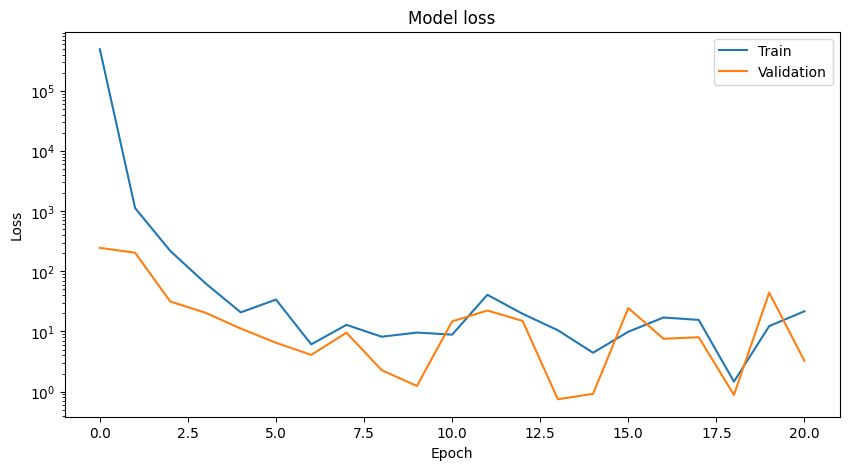

In [ ]:

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale("log")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()